# Object Detection with Neural Networks

## A toy example

This example is adapted from the tutorial:

[Object detection with neural networks — a simple tutorial using keras](https://medium.com/towards-data-science/object-detection-with-neural-networks-a4e2c46b4491)

In this tutorial, we will look at object detection — finding out which objects are in an image. For example, imagine a self-driving car that needs to detect other cars on the road. There are lots of complicated algorithms for object detection. They often require huge datasets, very deep convolutional networks and long training times. To make this tutorial easy to follow along, we’ll apply two simplifications: 1) We don’t use real photographs, but images with abstract geometric shapes. This allows us to bootstrap the image data and use simpler neural networks. 2) We predict a fixed number of objects in each image. This makes the entire algorithm a lot, lot easier (it’s actually surprisingly simple besides a few tricks).

In [1]:
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Data preparation

We will deal with images with simple objects of different shapes. For simplicity, all images will have the same size, are black&white and have two objects. We will create the dataset ourselves with these lines of code:

In [2]:
num_imgs = 50000

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        # half of the objects will be triangles, the other half are squares
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x+width, y:y+height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size=2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
            
imgs.shape, bboxes.shape

((50000, 16, 16), (50000, 2, 4))

We have created a dataset of 50k images. Let's look at some of the samples:

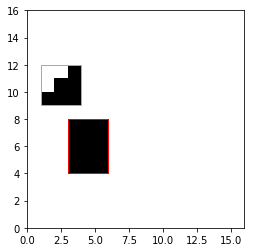

In [3]:
i=1
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', 
           origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                                                     ec='r' if shape[0] == 0 else 'y', fc='none'))

We pre-process the images by subtracting the mean and dividing by the std of pixel intensities.

In [4]:
X = (imgs - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)
X = X.reshape((X.shape[0],X.shape[1],X.shape[2],1))
X.shape

(50000, 16, 16, 1)

Box coordinates are also pre-processed so that instead of predicting raw pixel coordinates `(w,h)`, we predict `(w/W, w/H)`. We can decode these values easily at test time.

In [5]:
y = np.concatenate([bboxes / img_size, shapes], axis=-1).reshape(num_imgs, -1)
y.shape

(50000, 10)

`y` is a vector of 10 positions (5 for each object). Out of the 5 values, 4 are the pixel coordinates, and the 4th is the one indicating wether the object is a triangle or a square.

In [6]:
y[0]

array([ 0.125 ,  0.375 ,  0.3125,  0.4375,  0.    ,  0.5625,  0.375 ,
        0.375 ,  0.375 ,  1.    ])

Let's split our data into train/test splits. We will use 80% of the data for training, and the rest for testing.

In [7]:
i_train = int(0.6 * num_imgs)
i_val = int(0.7 * num_imgs)

train_X = X[:i_train]
val_X = X[i_train:i_val]
test_X = X[i_val:]
train_y = y[:i_train]
val_y = y[i_train:i_val]
test_y = y[i_val:]
test_imgs = imgs[i_val:]
test_bboxes = bboxes[i_val:]

### Model

We will use a simple model with a single hidden Dense layer with 256 dimensions, and a Dense layer of 10 dimensions. We will use MSE as our loss function to train the model.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten

Using TensorFlow backend.


In [ ]:
model = Sequential([
        Conv2D(filters=64,kernel_size=3, input_shape=(X.shape[1:]),activation='relu'), 
        Conv2D(filters=32,kernel_size=3,activation='relu'),
        Flatten(),
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                46090     
Total params: 65,194
Trainable params: 65,194
Non-trainable params: 0
_________________________________________________________________


### Training

Let's go ahead and train the model.

In [ ]:
n_epochs = 50
history = model.fit(train_X,train_y,batch_size=32,epochs=n_epochs,validation_data=(val_X,val_y))

Train on 30000 samples, validate on 5000 samples
Epoch 1/50


In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Evaluation

Let's see some results. We can use `model.predict()` to get the output of our model for all our test set. 

In [ ]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

In [ ]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', 
               extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], 
                                                         ec='r' if pred_shape[0] <= 0.5 else 'y', fc='none'))

Both bounding boxes seem to be in the middle of the rectangles. What happened? Imagine the following situation: We train our network on the leftmost image in the plot above. Let’s say that the expected bounding box of the left rectangle is at position 1 in the target vector (x1, y1, w1, h1), and the expected bounding box of the right rectangle is at position 2 in the vector (x2, y2, w2, h2). Apparently, our optimizer will change the parameters of the network so that the first predictor moves to the left, and the second predictor moves to the right. Imagine now that a bit later we come across a similar image, but this time the positions in the target vector are swapped (i.e. left rectangle at position 2, right rectangle at position 1). Now, our optimizer will pull predictor 1 to the right and predictor 2 to the left — exactly the opposite of the previous update step! In effect, the predicted bounding boxes stay in the center. And as we have a huge dataset (40k images), there will be quite a lot of such “duplicates”.

The solution is to “assign” each predicted bounding box to a rectangle during training. Then, the predictors can learn to specialize on certain locations and/or shapes of rectangles. In order to do this, we process the target vectors after every epoch: For each training image, we calculate the mean squared error between the prediction and the target A) for the current order of bounding boxes in the target vector (i.e. x1, y1, w1, h1, x2, y2, w2, h2) and B) if the bounding boxes in the target vector are flipped (i.e. x2, y2, w2, h2, x1, y1, w1, h1). If the MSE of A is greater than B, we leave the target vector as is; if the MSE of B is greater than A, we flip the vector.

### Training with assignments

We will write a function that permutes the ground truth labels based on the obtained mean square error. This function uses the library `munkres` to compute the minimum cost assignment given the matrix of costs.

In [ ]:
from munkres import Munkres

def flip_targets(pred_ys,ys,m):

    for sample, (pred_y,y) in enumerate(zip(pred_ys,ys)):
        pred_y = pred_y.reshape(num_objects, -1)
        y = y.reshape(num_objects, -1)
        
        pred_bboxes = pred_y[:, :4]
        y_bboxes = y[:, :4]
        costs = np.zeros((num_objects,num_objects))
        for i, y_bbox in enumerate(y_bboxes):
            for j, pred_bbox in enumerate(pred_bboxes):
                costs[i, j] += np.mean(np.square(y_bbox - pred_bbox))
                
        # matrix of assignments
        idxs = np.array(m.compute(costs))[:,1]
        y_flipped = y[idxs]
        ys[sample] = y_flipped.flatten()
        
    return ys

Let's define the model again:

In [ ]:
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile('adadelta', 'mse')

We will train with an external loop this time. This will allow us to flip the ground truth at the end of each epoch.

In [ ]:
m = Munkres()
for epoch in range(n_epochs):
    print ('Epoch', epoch)
    model.fit(train_X,train_y,batch_size=512,epochs=1,validation_data=(val_X,val_y))
    pred_y_train = model.predict(train_X)
    pred_y_val = model.predict(val_X)
    
    train_y = flip_targets(pred_y_train,train_y,m)
    val_y = flip_targets(pred_y_val,val_y,m)
    

And now, let's decode some predictions:

In [ ]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

In [ ]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', 
               origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], 
                                                         ec='r' if pred_shape[0] <= 0.5 else 'y', fc='none'))

It still is not perfect, but remember that we are using a very simple fully connected network ! You can try to change the model and see

## Let's get real...

Recognizing shapes is a cool and easy example, but obviously it’s not what you want to do in the real world (there aren’t that many abstract 2D shapes in nature, unfortunately). Also, our algorithm can only predict a fixed number of bounding boxes per image. In the real world, however, you have diverse scenarios: A small side road may have no cars on it, but as soon as you drive on the highway, you have to recognize hundreds of cars at the same time.